In [1]:
import argparse
import time
import sys
import os
from pathlib import Path
import mlflow
import mlflow.pytorch
from sklearn.metrics import roc_auc_score
import numpy as np

# Add project root to path BEFORE importing from src
# project_root = Path(__file__).resolve().parents[1]
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

# Now import from src
import segmentation_models_pytorch as smp
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from src.data.datasets import SimpleIberFireSegmentationDataset


In [2]:
model_name = "resnet34_v7.pth"
model_path = project_root / "models" / model_name


In [3]:
# load model
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

ZARR_PATH = project_root / "data" / "gold" / "IberFire_coarse32_time1.zarr"
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

if True:
        feature_vars = [
            # Dynamic features (time-dependent)
            "FAPAR",
            "FWI",
            "LAI",
            "LST",
            "NDVI",
            "RH_max",
            "RH_mean",
            "RH_min",
            "RH_range",
            "SWI_001",
            "SWI_005",
            "SWI_010",
            "SWI_020",
            "is_holiday",
            #"is_near_fire",
            "surface_pressure_max",
            "surface_pressure_mean",
            "surface_pressure_min",
            "surface_pressure_range",
            "t2m_max",
            "t2m_mean",
            "t2m_min",
            "t2m_range",
            "total_precipitation_mean",
            "wind_direction_at_max_speed",
            "wind_direction_mean",
            "wind_speed_max",
            "wind_speed_mean",
            # CLC Level-3 classes (year-aware bases)
            "CLC_1",
            "CLC_2",
            "CLC_3",
            "CLC_4",
            "CLC_5",
            "CLC_6",
            "CLC_7",
            "CLC_8",
            "CLC_9",
            "CLC_10",
            "CLC_11",
            "CLC_12",
            "CLC_13",
            "CLC_14",
            "CLC_15",
            "CLC_16",
            "CLC_17",
            "CLC_18",
            "CLC_19",
            "CLC_20",
            "CLC_21",
            "CLC_22",
            "CLC_23",
            "CLC_24",
            "CLC_25",
            "CLC_26",
            "CLC_27",
            "CLC_28",
            "CLC_29",
            "CLC_30",
            "CLC_31",
            "CLC_32",
            "CLC_33",
            "CLC_34",
            "CLC_35",
            "CLC_36",
            "CLC_37",
            "CLC_38",
            "CLC_39",
            "CLC_40",
            "CLC_41",
            "CLC_42",
            "CLC_43",
            "CLC_44",
            # CLC aggregated proportions (year-aware bases)
            "CLC_agricultural_proportion",
            "CLC_arable_land_proportion",
            "CLC_artificial_proportion",
            "CLC_artificial_vegetation_proportion",
            "CLC_forest_and_semi_natural_proportion",
            "CLC_forest_proportion",
            "CLC_heterogeneous_agriculture_proportion",
            "CLC_industrial_proportion",
            "CLC_inland_waters_proportion",
            "CLC_inland_wetlands_proportion",
            "CLC_marine_waters_proportion",
            "CLC_maritime_wetlands_proportion",
            "CLC_mine_proportion",
            "CLC_open_space_proportion",
            "CLC_permanent_crops_proportion",
            "CLC_scrub_proportion",
            "CLC_urban_fabric_proportion",
            "CLC_waterbody_proportion",
            "CLC_wetlands_proportion",
            # Other static features
            "aspect_1",
            "aspect_2",
            "aspect_3",
            "aspect_4",
            "aspect_5",
            "aspect_6",
            "aspect_7",
            "aspect_8",
            "aspect_NODATA",
            "dist_to_railways_mean",
            "dist_to_railways_stdev",
            "dist_to_roads_mean",
            "dist_to_roads_stdev",
            "dist_to_waterways_mean",
            "dist_to_waterways_stdev",
            "elevation_mean",
            "elevation_stdev",
            "is_natura2000",
            "is_sea",
            "is_spain",
            "is_waterbody",
            "roughness_mean",
            "roughness_stdev",
            "slope_mean",
            "slope_stdev",
            # Year-aware population density (popdens_YYYY family)
            "popdens",
        ]

in_channels = len(feature_vars)

####

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,        
    in_channels=in_channels,
    classes=1,
    activation=None,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load the checkpoint (new format: state dict only, no epoch/optimizer info)
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)



<All keys matched successfully>

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/gold/IberFire_coarse32_time1.zarr
[SimpleDataset] Filtering time range: 2008-01-01 to 2024-12-31
[SimpleDataset] Total usable time steps: 6209
[SimpleDataset] Time steps after mode='all': 6209
[SimpleDataset] Dynamic vars (time-dependent): ['FAPAR', 'FWI', 'LAI', 'LST', 'NDVI', 'RH_max', 'RH_mean', 'RH_min', 'RH_range', 'SWI_001', 'SWI_005', 'SWI_010', 'SWI_020', 'is_holiday', 'surface_pressure_max', 'surface_pressure_mean', 'surface_pressure_min', 'surface_pressure_range', 't2m_max', 't2m_mean', 't2m_min', 't2m_range', 'total_precipitation_mean', 'wind_direction_at_max_speed', 'wind_direction_mean', 'wind_speed_max', 'wind_speed_mean']
[SimpleDataset] Static vars (no time dimension, broadcast in time): ['aspect_1', 'aspect_2', 'aspect_3', 'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8', 'aspect_NODATA', 'dist_to_railways_mean', 'dist_to_railways_stdev', 'dist_to_roads_mean', 'dist_to_ro

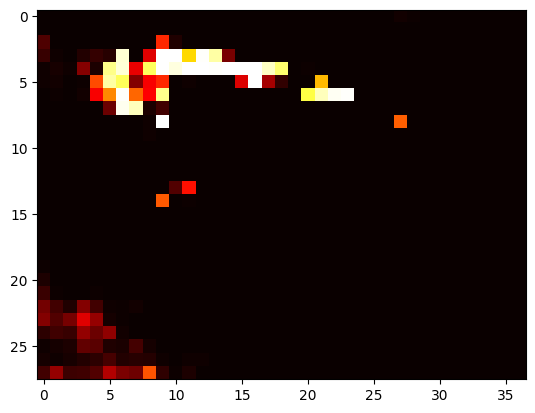

In [4]:
import matplotlib.pyplot as plt
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2008-01-01",
    time_end="2024-12-31",
    feature_vars=feature_vars,
    label_var="is_fire",
    spatial_downsample=1,
    lead_time=1,
    compute_stats=False,
    stats_path=project_root / "stats" / "simple_iberfire_stats_train.json"
)
X, y = test_ds[0]
X = X.unsqueeze(0).to(device).float()
model.eval()
with torch.no_grad():
    out = model(X)
    probs = torch.sigmoid(out).cpu().numpy()
image = probs[0, 0, :, :]
plt.imshow(image, cmap="hot")
print("Loaded model output shape:", out.shape)

In [13]:
def compare_prediction(model, ds, date_str: str, device='mps'):
    idxs = [i for i in range(len(ds)) if str(ds.get_time_value(i))[:10] == date_str]
    if not idxs:
        print(f"No sample found for date {date_str}")
        return
    idx = idxs[0]
    print(f"Using sample index {idx} for date {date_str} (matches={len(idxs)})")
    print("ds.get_time_value(idx) =", ds.get_time_value(idx))

    X, y = ds[idx]
    print("X shape:", tuple(X.shape), "y shape:", tuple(y.shape))
    print("X stats:", float(X.mean()), float(X.std()), float(X.min()), float(X.max()))
    print("y sum:", float(y.sum()), "y ratio:", float(y.mean()))

    model.eval()
    with torch.no_grad():
        logits = model(X.unsqueeze(0).to(device).float())
        probs = torch.sigmoid(logits).cpu().squeeze().numpy()

    print("probs stats:", float(probs.mean()), float(probs.std()), float(probs.min()), float(probs.max()))

    target = y.squeeze().numpy()
    mask = (target > 0.5).astype(float)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmin, vmax = np.percentile(probs, [1, 99])
    im_pred = ax.imshow(probs, cmap="magma", vmin=vmin, vmax=vmax, origin="lower")
    plt.colorbar(im_pred, ax=ax, fraction=0.046, pad=0.04, label="Predicted prob")

    ax.imshow(np.ma.masked_where(mask == 0, mask), cmap="Reds", origin="lower", alpha=0.9)

    ax.set_title(f"Prediction vs GT overlay\nindex={idx} date={date_str}")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

Using sample index 2635 for date 2015-03-20 (matches=1)
ds.get_time_value(idx) = 2015-03-20T00:00:00.000000000
X shape: (116, 28, 37) y shape: (1, 28, 37)
X stats: nan nan nan nan
y sum: 0.0 y ratio: 0.0
probs stats: 0.04108265042304993 0.17031750082969666 0.0 0.9999853372573853


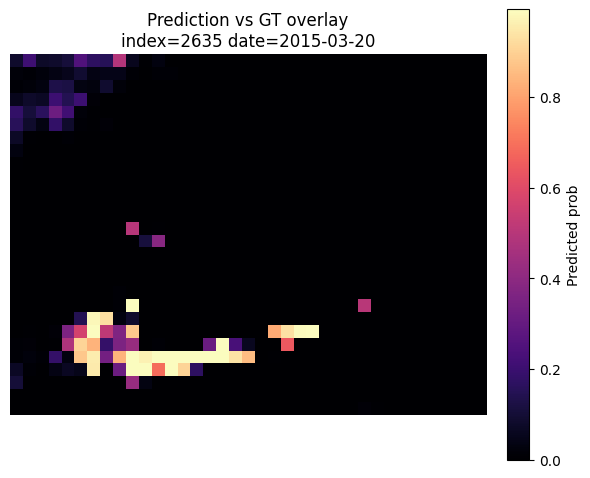

In [15]:
compare_prediction(model, test_ds, "2015-03-20")

In [17]:
idx1, idx2 = 976, 2635
ds = test_ds
X1, y1 = ds[idx1]
X2, y2 = ds[idx2]

print("date1:", ds.get_time_value(idx1), "date2:", ds.get_time_value(idx2))

print("X mean/std/min/max #1:", float(X1.mean()), float(X1.std()), float(X1.min()), float(X1.max()))
print("X mean/std/min/max #2:", float(X2.mean()), float(X2.std()), float(X2.min()), float(X2.max()))

print("X mean abs diff:", float((X1 - X2).abs().mean()))
print("X max abs diff:", float((X1 - X2).abs().max()))
print("X allclose:", torch.allclose(X1, X2, atol=1e-6))

# per-channel change (top 10 channels that actually differ)
per_ch = (X1 - X2).abs().mean(dim=(1,2))
vals, inds = torch.topk(per_ch, k=min(10, per_ch.numel()))
print("top changing channels:", inds.tolist())
print("their mean abs diffs:", vals.tolist())

date1: 2010-09-03T00:00:00.000000000 date2: 2015-03-20T00:00:00.000000000
X mean/std/min/max #1: nan nan nan nan
X mean/std/min/max #2: nan nan nan nan
X mean abs diff: nan
X max abs diff: nan
X allclose: False
top changing channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
their mean abs diffs: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [18]:
model.eval()
with torch.no_grad():
    p1 = torch.sigmoid(model(X1.unsqueeze(0).to(device).float())).cpu()[0,0]
    p2 = torch.sigmoid(model(X2.unsqueeze(0).to(device).float())).cpu()[0,0]

print("pred mean/std #1:", float(p1.mean()), float(p1.std()))
print("pred mean/std #2:", float(p2.mean()), float(p2.std()))
print("pred mean abs diff:", float((p1 - p2).abs().mean()))
print("pred max abs diff:", float((p1 - p2).abs().max()))
print("pred corr:", float(np.corrcoef(p1.flatten(), p2.flatten())[0,1]))

pred mean/std #1: 0.041082654148340225 0.1703997552394867
pred mean/std #2: 0.041082654148340225 0.1703997552394867
pred mean abs diff: 0.0
pred max abs diff: 0.0
pred corr: 1.0


In [19]:
nan_per_ch = torch.isnan(X1).any(dim=(1,2))
nan_channels = nan_per_ch.nonzero(as_tuple=False).squeeze(1).tolist()
print("Channels with NaNs:", nan_channels)
print("Num channels with NaNs:", len(nan_channels), "out of", X1.shape[0])

Channels with NaNs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Num channels with NaNs: 26 out of 116
